## Table of contents:
* [Set env](#set_env)
* [General information on Reactome biopax file](#general_reactome)
    * [Query 1: Number of elements for each biopax types](#query1)
* [Complexes](#complexes)
    * [Complexes in BioPAX specifications](#complexes_in_biopax)
    * [Complexes in Reactome](#complex_reactome)
        * [Summary](#summary)
        * [Query 2: How many black-box complexes?](#query2) 
        * [Query 3: How many complexes have at least one component? ](#query3)
        * [Query 4: How many complexes have at least one component that is a complex? ](#query4)
        * [Query 5: How many complexes have at least one component, none of which is a complex? ](#query5)
        * [Query 6: How many complexes have at least one component that is a blackbox complex ](#query6)
        * [Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? ](#query7)
        * [Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? ](#query8)
        * [Query 9: How many complexes, that are not black boxes, are a component of at least another complex? ](#query9)
        * [Query 10: Distribution of the number of direct components by complex ](#query10)  
        * [Query 11: Distribution of the number of complexes a complex is a component of](#query11)
        * [Query 12:  How many interactions directly involve an invalid complex? ?](#query12)
        * [Query 13: How many different components are involved in the invalid complexes?](#query13)
        * [Query 14: How many interactions directly involve a component of an invalid complex?](#query14)
        * [Query 15: How many interactions involve a complex having a direct component that is a component of an invalid complex?](#query15)
        * [Query 16: How many interactions directly and indirectly involve these components?](#query16)

    * [Identify the redundant complexes](#identify_redundant)
        * [Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular localisation?](#query17)
        * [How many cliques?](#cliques)
    * [Fix the invalid complexes](#fix_complexes)
        

### Environment <a class="anchor" id="set_env"></a>

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

import time
import jwt
import pathlib

import uri_utils
import complexComponents

In [2]:
reactomeVersion = 81
species = 48895
# species = 

endpointURL = "http://localhost:3030/REACTOME_RATTUS/query"
rdfFormat = "turtle"

workspace = "."
path_results = workspace+'/results-'+str(reactomeVersion)+'-'+str(species)
if not os.path.exists(path_results) :
  os.makedirs(path_results)

prefixesDict = uri_utils.readPrefixesFromFile("defaultPrefixes-release" + 
                                              str(reactomeVersion) + ".json")


In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>

PREFIX up:<http://purl.uniprot.org/core/>
PREFIX udb: <http://purl.uniprot.org/database/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX reactome: <http://www.reactome.org/biopax/""" + str(reactomeVersion)+"""/"""+str(species)+"""#>
"""

### General information on the dataset (Reactome Biopax Homo Sapiens v79) <a class="anchor" id="general_reactome"></a>

Query 1: Number of elements for each biopax types <a class="anchor" id="query1"></a>

In [4]:
## Reactome - initial file
## Version xml:base="http://www.reactome.org/biopax/79/48887#"> (2022-02-03)

## Number of elements for each biopax types
query="""
# Number of elements for each biopax types in reactome
SELECT ?type (COUNT(DISTINCT(?element)) AS ?nb_elements)
WHERE {
  ?element a ?type.
  FILTER(STRSTARTS(STR(?type),str(bp3:)) )
}
GROUP BY ?type
ORDER BY DESC (?nb_elements)
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,type,nb_elements
0,http://www.biopax.org/release/biopax-level3.owl#UnificationXref,102190
1,http://www.biopax.org/release/biopax-level3.owl#SequenceSite,37254
2,http://www.biopax.org/release/biopax-level3.owl#Stoichiometry,24551
3,http://www.biopax.org/release/biopax-level3.owl#PublicationXref,23231
4,http://www.biopax.org/release/biopax-level3.owl#Protein,19871
5,http://www.biopax.org/release/biopax-level3.owl#FragmentFeature,17314
6,http://www.biopax.org/release/biopax-level3.owl#SequenceInterval,17314
7,http://www.biopax.org/release/biopax-level3.owl#Complex,9645
8,http://www.biopax.org/release/biopax-level3.owl#Evidence,9596
9,http://www.biopax.org/release/biopax-level3.owl#PathwayStep,9569


### Complexes <a class="anchor" id="complexes"></a>

#### Complexes in BioPAX specifications <a class="anchor" id="complexes_in_biopax"></a>

- **Complex** (BioPAX-level3 page 48)
    - physical product of an interaction
    - **complexes should not be defined recursively** (a complex should not be a component of another complex)
    - **exceptions are black box complexes** i.e. complexes in which the component property is empty
    - the `bp3:component` property
        - has domain: `bp3:Complex`
        - has range: `bp3:PhysicalEntity`, which subclasses are:
            - `bp3:Dna`
            - `bp3:Rna`
            - `bp3:Protein`
            - `bp3:Complex` warning: black box complexes only!
            - `bp3:SmallMolecule`
- **Black box complex**
- **Redundant complexes** are complexes having different identifiers, possibly from different databases but having the same chemical and physical properties
    - redundant complexes form equivalence classes

#### Complexes in Reactome <a class="anchor" id="complex_reactome"></a>
![](./2022_03_09_Complex_Biopax.png)

#### Summary <a class="anchor" id="summary"></a>
- complexes: 14840
- black box complexes: 858
- complexes that have at least one component: 13982
    - (complexes that are not black box complexes)
    - control: 14840-858=13982
    - they have up to 65 direct components
- complexes that have at least one component that is a complex: 6249
    - might be ok if all these components are black box complexes
    - 44.7% of 13982 
    - 42.1% of 14776 
    - control: complexes that have at least one component, none of which is a complex: 7733 (13982-6249=7733)
- complexes that have at least one component that is a black box complex: ~739~ 737
    - 11.8% of 6249 
- complexes that have at least one component that is a complex, and all its components that are complexes are actually black box complexes: ~517~ 515 
    - was expecting more, ideally 6249 
    - 8.2% of 6249 
- complexes that have at least one component that is a complex but not a black box complex: ~5710~ 5734
    - **these complexes should be fixed**
    - 38.6% of 14840
    - 41% of 13982
- complexes that are not black boxes but are a component of at least another complex: 4333
    - **they are the ones to look at for fixing the 5734**
    - they can be valid (i.e. all their components that are complexes are black box complexes) or invalid
    - they can be involved in chemical reactions (and therefore we should keep them, possibly after making them compliant and after detecting redundancies) or not (and these we can probably discard)
    -  ~1032~  of them are the direct component of more than one complex (max = direct component of 65 complexes)

Query 2: How many black-box complexes? <a class="anchor" id="query2"></a>

In [5]:
## OD
query="""
# Blackbox complexes

SELECT (COUNT(DISTINCT ?complexBB) AS ?nbComplexesBB)
WHERE {
  ?complexBB rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexBB bp3:component ?complexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexesBB
0,515


Query 3: How many complexes have at least one component? <a class="anchor" id="query3"></a>

In [6]:
## OD
query="""
# Complexes that have at least one component
# i.e. complexes that are not blackbox complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,9130


Query 4: How many complexes have at least one component that is a complex? <a class="anchor" id="query4"></a>

In [7]:
## OD
query="""
# Complexes that have at least one component that is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,4043


Query 5: How many complexes have at least one component, none of which is a complex? <a class="anchor" id="query5"></a>

In [8]:
## OD
query="""
# Complexes that have at least one component, none of which is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,5087


Query 6: How many complexes have at least one component that is a blackbox complex  <a class="anchor" id="query6"></a>

In [9]:
## OD
query="""
# Complexes that have at least one component that is a blackbox complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexComponent bp3:component ?someComplexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,423


Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? <a class="anchor" id="query7"></a>

In [10]:
## OD
query="""
# Complexes that have at least one component that is a complex, 
# and all its components that are complexes are actually black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
    ?someComplexComponent bp3:component ?someComplexComponentComponent .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,263


Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? <a class="anchor" id="query8"></a>

Number of invalid complexes

In [11]:
## OD
query="""
# All invalid complexes
# Complexes that have at least one component that is a complex, but not a black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  ?complexComponent bp3:component ?someComplexComponentComponent .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3780


Query 9: How many complexes, that are not black-boxes, are a component of at least another complex? <a class="anchor" id="query9"></a>

In [12]:
## OD
query="""
# Complexes that are not black boxes but are a component of at least another complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  
  ?superComplex bp3:component ?complex .
  ?superComplex rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3148


Query 10: Distribution of the number of direct components by complex <a class="anchor" id="query10"></a>

In [13]:
## OD
query="""
# Distribution of the number of direct components by complex

SELECT ?complex (COUNT(DISTINCT ?complexComponent) AS ?nbComponents)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?complex bp3:component ?complexComponent . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?complex bp3:component ?complexComponent . 
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbComponents"] = pandas.to_numeric(df["nbComponents"])
#df.to_csv("./direct_components.csv")
df["nbComponents"].describe()

count    9645.000000
mean        2.300778
std         2.891234
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        65.000000
Name: nbComponents, dtype: float64

Text(0.5, 0.98, 'Distribution of the number of direct components by complex')

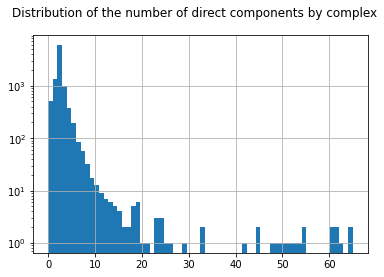

In [14]:
df['nbComponents'].hist(bins=df['nbComponents'].max()+1, log=True)
plt.suptitle("Distribution of the number of direct components by complex")

Query 11: Distribution of the number of complexes a complex is a component of<a class="anchor" id="query11"></a>

Text(0.5, 0.98, 'Distribution of the number of complexes a complex is a component of')

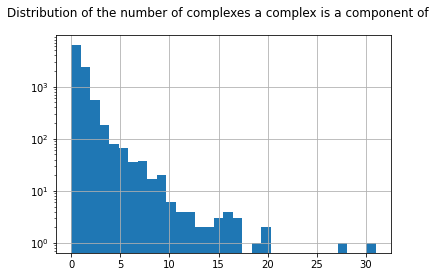

In [15]:
## OD
query="""
# Distribution of the number of complexes a complex is a component of

SELECT ?complex (COUNT(DISTINCT ?whole) AS ?nbWholes)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?whole bp3:component ?complex . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?whole bp3:component ?complex .
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbWholes"] = pandas.to_numeric(df["nbWholes"])
df["nbWholes"].describe()
df["nbWholes"].hist(bins=df['nbWholes'].max()+1, log=True)
plt.suptitle("Distribution of the number of complexes a complex is a component of")

Query 12: How many interactions **directly** involve invalid complexes? <a class="anchor" id="query12"></a>

In [16]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?interaction) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?complex .
  
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,13276


Query 13: How many different components (proteins, small molecules et physical entites) are involved in the invalid complexes? <a class="anchor" id="query13"></a>

In [17]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?leafComponent) AS ?nbInvalidComplexesComponents)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?someComplexComponentComponent .
  
  ?invalidComplex bp3:component+ ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInvalidComplexesComponents
0,5602


The 5,734 invalid complexes are (in)directly composed of 7,119 distinct entities that are not complexes, interactions, DNA or RNA. Nb: this excludes black-box complexes.

Query 14: How many interactions **directly** involve these components? <a class="anchor" id="query14"></a>

In [18]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#All interactions that have a participant that is a component of an invalid complex 

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .} 
  
  ?interact ?hasParticipant ?leafComponent .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,4760


Query 15: How many interactions involve a complex having a **direct** component that is a component of an invalid complex?  <a class="anchor" id="query15"></a>

Interactions involving a complex composed directly of a component of an invalid complex

In [19]:
query="""
# All interactions that have a participant that is a complex having a direct component that is a component of an invalid complex (excludes black-box complexes)

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  ?interactParticipant bp3:component? ?leafComponent . # 0 or 1 path
  ?interact ?hasParticipant ?interactParticipant .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,7170


Query 16: How many interactions **directly** and **indirectly** involve these components? <a class="anchor" id="query16"></a>

Interactions involving a complex (valid or invalid) composed indirectly of a component of an invalid complex or the component itself

In [20]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#Interactions involving a complex composed indirectly of a component of an invalid complex

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  
  ?interactParticipant bp3:component* ?leafComponent . # 0 or more paths
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .  
  ?interact ?hasParticipant ?interactParticipant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,7656


### Identify the redundant complexes <a class="anchor" id="identify_redundant"></a>

Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular location? <a class="anchor" id="query17"></a>

In [21]:
## OD CJ
query = """
# Retrieve redundant complexes i.e. pairs of complexes having different identifiers but the same components with the same stoichiometric coefficients
SELECT DISTINCT ?complex1  ?complex2 ?loc1# ?id1 ?id2 #?comp ?stoichioValue1 ?stoichioValue2

WHERE {
  #VALUES ?complex { reactome:Complex3 reactome:Complex7 reactome:Complex4 reactome:Complex5 reactome:Complex6 reactome:Complex8 reactome:Complex101 reactome:Complex102 }
  #VALUES ?complex { reactome:Complex102 }
  
  ?complex1 rdf:type bp3:Complex .
  # ?complex1 and ?complex2 have at least 1 common component (to avoid matching all the pairs of blackbox complexes that do not have any components)
  ?complex1 bp3:component ?commonComp .
  ?complex2 bp3:component ?commonComp .
  ?complex2 rdf:type bp3:Complex .
  ?complex1 bp3:cellularLocation ?loc1 .
  ?complex2 bp3:cellularLocation ?loc1 .
  FILTER (str(?complex1) < str(?complex2))
  # ?complex1 and ?complex2 do not have any common component that has different stoichiometric coefficients between the two complexes
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp .
    ?complex2 bp3:component ?comp .
    #?complex1 bp3:cellularLocation ?loc1 .
    ?complex1 bp3:componentStoichiometry ?stoichio1 .
    ?stoichio1 bp3:physicalEntity ?comp .
    ?stoichio1 bp3:stoichiometricCoefficient ?stoichioValue1 .

    ?complex2 bp3:componentStoichiometry ?stoichio2 .
    ?stoichio2 bp3:physicalEntity ?comp .
    #?complex2 bp3:cellularLocation ?loc2 .
    ?stoichio2 bp3:stoichiometricCoefficient ?stoichioValue2 .
    FILTER (?stoichioValue1 != ?stoichioValue2)
    #FILTER (?loc1 != ?loc2)
  }


  # all the direct components of ?complex1 are also components of ?complex2
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp1 .
    FILTER NOT EXISTS {
      ?complex2 bp3:component ?comp1 .
    }
  }
  # all the direct components of ?complex2 are also components of ?complex1
  FILTER NOT EXISTS {
    ?complex2 bp3:component ?comp2 .
    FILTER NOT EXISTS {
      ?complex1 bp3:component ?comp2 .
    }
  }
 OPTIONAL{ ?complex1 bp3:xref ?xref1 .
    ?xref1 bp3:db "ComplexPortal" .
    ?xref1 bp3:id ?id1 . }
  
OPTIONAL{ ?complex2 bp3:xref ?xref2 .
    ?xref2 bp3:db "ComplexPortal" .
    ?xref2 bp3:id ?id2 . }
}
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,complex1,complex2,loc1
0,http://www.reactome.org/biopax/81/48895#Complex1607,http://www.reactome.org/biopax/81/48895#Complex7971,http://www.reactome.org/biopax/81/48895#CellularLocationVocabulary6
1,http://www.reactome.org/biopax/81/48895#Complex2283,http://www.reactome.org/biopax/81/48895#Complex2284,http://www.reactome.org/biopax/81/48895#CellularLocationVocabulary1
2,http://www.reactome.org/biopax/81/48895#Complex3550,http://www.reactome.org/biopax/81/48895#Complex3551,http://www.reactome.org/biopax/81/48895#CellularLocationVocabulary3
3,http://www.reactome.org/biopax/81/48895#Complex8632,http://www.reactome.org/biopax/81/48895#Complex8633,http://www.reactome.org/biopax/81/48895#CellularLocationVocabulary4


How many cliques? <a class="anchor" id="cliques"></a>

In [22]:
cliques = {df["complex1"][0] : [df["complex2"][0]]}
for row in df.itertuples(index=False):
    if row[0] in cliques :
        cliques[row[0]].append(row[1])
    elif row[1] in cliques :
        cliques[row[1]].append(row[0])
    else :
        found = False
        for i in cliques :
            if row[0] in cliques[i]:
                cliques[i].append(row[1])
                found = True
                break
            elif row[1] in cliques[i]:
                cliques[i].append(row[0])
                found = True
                break
        if not found :
            cliques[row[0]] = list()
            cliques[row[0]].append(row[1])
       
len(cliques) 

4

* * *
### Fix the invalid complexes <a class="anchor" id="fix_complexes"></a>

- step 0: retrieve Reactome
       wget https://reactome.org/download/current/biopax.zip
       unzip biopax.zip Homo_sapiens.owl
       echo "Reactome version: $(expr "$(grep xml:base Homo_sapiens.owl)" : '.*http:\/\/www.reactome.org\/biopax\/\([[:digit:]]*\).*')"

- step 1: setup SPARQL endpoint with reactome
       # broken with fuseki-4.4.0: 
       # temporary fix
       ${FUSEKI_HOME}/fuseki-server --mem --update /reactome
       # then manually load Homo_sapiens.owl

- step 2: export the valid complexes

- step 3: export the fixed invalid complexes

- step 4: export reactome without complexes

- step 5: merge files 

![]("./Figure_drawio/2022_03_17_Stoichio.pdf")

Function 1: fix invalid complexes <a class="anchor" id="function1"></a>

In [23]:
def fixInvalidComplexes():
    ##### FIX INVALID COMPLEXES
    queryPath = 'queries/template-fixInvalidComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
#     sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    nbInvalidComplexes = len(results["results"]["bindings"])
    i = 0
    for result in results["results"]["bindings"]:
        print("{}\t{}\t{}".format(i, time.time()-startTime, result['invalidComplex']['value']))
        validGraph = rdflib.Graph()
        validGraph.bind("bp3","http://www.biopax.org/release/biopax-level3.owl#")
        complexComponents.getRepresentationBiopaxValid(endpointURL, result['invalidComplex']['value'], prefixesDict=prefixesDict, targetGraph=validGraph, rdfFormat="turtle", biopaxFilePath="")
        with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-" + result['invalidComplex']['value'].replace("http://www.reactome.org/biopax/" + str(reactomeVersion) + "/" + str(species) + "#", "") + "-valid.ttl", 'w',encoding="utf-8") as rdfFile:
            rdfFile.write(validGraph.serialize(format=rdfFormat))#.decode('UTF-8'))
        i += 1
    
     #${JENA_HOME}/bin/riot --time --output=Turtle result/reactome-v81-Complex*.ttl > reactome-v81-complexes-invalid-fixed.ttl

Function 2: export valid complexes <a class="anchor" id="function2"></a>

In [24]:
def exportValidComplexes():
    ##### EXPORT VALID PART OF REACTOME
    queryPath = 'queries/template-extractValidComplexes-construct.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(rdfFormat)
    results = sparql.query().convert()
    validGraph = rdflib.Graph()
    validGraph.parse(data=results, format=rdfFormat)

    with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-complexes-valid.ttl", 'w', encoding="utf-8") as rdfFile:
        rdfFile.write(validGraph.serialize(format=rdfFormat).encode().decode('UTF-8'))

Function 3: delete all complexes  <a class="anchor" id="function3"></a>

In [25]:
def deleteAllComplexes():
    queryPath = 'queries/deleteOriginalComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict))
    print("Calling: " + endpointURL.replace("query", "update"))
    sparql = SPARQLWrapper(endpointURL.replace("query", "update"))
    sparql.setQuery(sparqlQuery)
    sparql.method = 'POST'
    #sparql.setReturnFormat(JSON)
    sparql.query()

In [26]:
validGraph = rdflib.Graph()
sparql = SPARQLWrapper(endpointURL)

In [27]:
startTime = time.time()
fixInvalidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

0	0.8785138130187988	http://www.reactome.org/biopax/81/48895#Complex1
1	1.3249990940093994	http://www.reactome.org/biopax/81/48895#Complex3
2	1.559945821762085	http://www.reactome.org/biopax/81/48895#Complex6
3	2.8306844234466553	http://www.reactome.org/biopax/81/48895#Complex13
4	4.169219255447388	http://www.reactome.org/biopax/81/48895#Complex7
5	5.228562116622925	http://www.reactome.org/biopax/81/48895#Complex11
6	5.78352689743042	http://www.reactome.org/biopax/81/48895#Complex14
7	7.293976783752441	http://www.reactome.org/biopax/81/48895#Complex16
8	8.90227484703064	http://www.reactome.org/biopax/81/48895#Complex17
9	9.989007711410522	http://www.reactome.org/biopax/81/48895#Complex21
10	11.645541667938232	http://www.reactome.org/biopax/81/48895#Complex22
11	13.336509466171265	http://www.reactome.org/biopax/81/48895#Complex23
12	15.813876867294312	http://www.reactome.org/biopax/81/48895#Complex25
13	16.37028217315674	http://www.reactome.org/biopax/81/48895#Complex26
14	16.9024691581

115	80.94118690490723	http://www.reactome.org/biopax/81/48895#Complex270
116	81.59411382675171	http://www.reactome.org/biopax/81/48895#Complex271
117	82.10355186462402	http://www.reactome.org/biopax/81/48895#Complex274
118	82.37842106819153	http://www.reactome.org/biopax/81/48895#Complex277
119	82.6422643661499	http://www.reactome.org/biopax/81/48895#Complex280
120	82.90796852111816	http://www.reactome.org/biopax/81/48895#Complex282
121	83.17063856124878	http://www.reactome.org/biopax/81/48895#Complex284
122	83.42504167556763	http://www.reactome.org/biopax/81/48895#Complex289
123	83.81461834907532	http://www.reactome.org/biopax/81/48895#Complex287
124	84.34753704071045	http://www.reactome.org/biopax/81/48895#Complex290
125	84.79262852668762	http://www.reactome.org/biopax/81/48895#Complex291
126	86.76506090164185	http://www.reactome.org/biopax/81/48895#Complex309
127	87.06388640403748	http://www.reactome.org/biopax/81/48895#Complex312
128	87.95013165473938	http://www.reactome.org/biopax

227	151.13913011550903	http://www.reactome.org/biopax/81/48895#Complex584
228	151.57068419456482	http://www.reactome.org/biopax/81/48895#Complex587
229	152.2084939479828	http://www.reactome.org/biopax/81/48895#Complex588
230	152.4619026184082	http://www.reactome.org/biopax/81/48895#Complex590
231	152.7072558403015	http://www.reactome.org/biopax/81/48895#Complex592
232	153.02775502204895	http://www.reactome.org/biopax/81/48895#Complex593
233	153.36955881118774	http://www.reactome.org/biopax/81/48895#Complex597
234	153.96935534477234	http://www.reactome.org/biopax/81/48895#Complex599
235	154.73405933380127	http://www.reactome.org/biopax/81/48895#Complex601
236	155.41914868354797	http://www.reactome.org/biopax/81/48895#Complex602
237	156.52606797218323	http://www.reactome.org/biopax/81/48895#Complex603
238	157.26404452323914	http://www.reactome.org/biopax/81/48895#Complex604
239	157.84430289268494	http://www.reactome.org/biopax/81/48895#Complex606
240	158.4176573753357	http://www.reactome

338	230.59917664527893	http://www.reactome.org/biopax/81/48895#Complex785
339	231.4496681690216	http://www.reactome.org/biopax/81/48895#Complex786
340	231.98996114730835	http://www.reactome.org/biopax/81/48895#Complex788
341	232.7342529296875	http://www.reactome.org/biopax/81/48895#Complex789
342	233.23339247703552	http://www.reactome.org/biopax/81/48895#Complex790
343	234.0287206172943	http://www.reactome.org/biopax/81/48895#Complex791
344	234.67346239089966	http://www.reactome.org/biopax/81/48895#Complex792
345	235.35874724388123	http://www.reactome.org/biopax/81/48895#Complex793
346	236.09417057037354	http://www.reactome.org/biopax/81/48895#Complex794
347	237.0560953617096	http://www.reactome.org/biopax/81/48895#Complex796
348	238.20836186408997	http://www.reactome.org/biopax/81/48895#Complex797
349	239.79146766662598	http://www.reactome.org/biopax/81/48895#Complex798
350	241.21804928779602	http://www.reactome.org/biopax/81/48895#Complex799
351	242.09009742736816	http://www.reactome

450	281.25191497802734	http://www.reactome.org/biopax/81/48895#Complex996
451	281.69369745254517	http://www.reactome.org/biopax/81/48895#Complex997
452	282.0641791820526	http://www.reactome.org/biopax/81/48895#Complex998
453	282.20718359947205	http://www.reactome.org/biopax/81/48895#Complex999
454	282.61127758026123	http://www.reactome.org/biopax/81/48895#Complex1000
455	282.90342116355896	http://www.reactome.org/biopax/81/48895#Complex1002
456	283.2841556072235	http://www.reactome.org/biopax/81/48895#Complex1003
457	283.58606791496277	http://www.reactome.org/biopax/81/48895#Complex1005
458	284.05717039108276	http://www.reactome.org/biopax/81/48895#Complex1006
459	284.438054561615	http://www.reactome.org/biopax/81/48895#Complex1007
460	284.73167300224304	http://www.reactome.org/biopax/81/48895#Complex1009
461	285.2101881504059	http://www.reactome.org/biopax/81/48895#Complex1010
462	285.6779043674469	http://www.reactome.org/biopax/81/48895#Complex1011
463	286.1677916049957	http://www.re

561	331.19032859802246	http://www.reactome.org/biopax/81/48895#Complex1213
562	331.66885447502136	http://www.reactome.org/biopax/81/48895#Complex1212
563	331.8837604522705	http://www.reactome.org/biopax/81/48895#Complex1214
564	332.3322808742523	http://www.reactome.org/biopax/81/48895#Complex1215
565	332.7077088356018	http://www.reactome.org/biopax/81/48895#Complex1216
566	332.91524624824524	http://www.reactome.org/biopax/81/48895#Complex1219
567	333.4692986011505	http://www.reactome.org/biopax/81/48895#Complex1220
568	333.98589062690735	http://www.reactome.org/biopax/81/48895#Complex1224
569	334.2074887752533	http://www.reactome.org/biopax/81/48895#Complex1228
570	334.5035719871521	http://www.reactome.org/biopax/81/48895#Complex1229
571	334.80572867393494	http://www.reactome.org/biopax/81/48895#Complex1234
572	335.0980279445648	http://www.reactome.org/biopax/81/48895#Complex1236
573	335.36210584640503	http://www.reactome.org/biopax/81/48895#Complex1239
574	335.66073775291443	http://ww

672	375.2050964832306	http://www.reactome.org/biopax/81/48895#Complex1405
673	375.3186101913452	http://www.reactome.org/biopax/81/48895#Complex1409
674	375.5530867576599	http://www.reactome.org/biopax/81/48895#Complex1410
675	375.8675949573517	http://www.reactome.org/biopax/81/48895#Complex1411
676	376.1498062610626	http://www.reactome.org/biopax/81/48895#Complex1412
677	376.53117179870605	http://www.reactome.org/biopax/81/48895#Complex1414
678	376.780113697052	http://www.reactome.org/biopax/81/48895#Complex1420
679	376.9320385456085	http://www.reactome.org/biopax/81/48895#Complex1422
680	377.1581201553345	http://www.reactome.org/biopax/81/48895#Complex1424
681	377.39252185821533	http://www.reactome.org/biopax/81/48895#Complex1425
682	377.57754778862	http://www.reactome.org/biopax/81/48895#Complex1429
683	377.80208015441895	http://www.reactome.org/biopax/81/48895#Complex1432
684	378.0254065990448	http://www.reactome.org/biopax/81/48895#Complex1430
685	378.18364930152893	http://www.reac

783	415.5728213787079	http://www.reactome.org/biopax/81/48895#Complex1612
784	415.83246088027954	http://www.reactome.org/biopax/81/48895#Complex1614
785	416.24373626708984	http://www.reactome.org/biopax/81/48895#Complex1616
786	416.50559425354004	http://www.reactome.org/biopax/81/48895#Complex1619
787	416.7229337692261	http://www.reactome.org/biopax/81/48895#Complex1638
788	418.3597481250763	http://www.reactome.org/biopax/81/48895#Complex1642
789	420.0021834373474	http://www.reactome.org/biopax/81/48895#Complex1643
790	434.6597900390625	http://www.reactome.org/biopax/81/48895#Complex1645
791	449.2569434642792	http://www.reactome.org/biopax/81/48895#Complex1646
792	465.3139626979828	http://www.reactome.org/biopax/81/48895#Complex1647
793	482.2437379360199	http://www.reactome.org/biopax/81/48895#Complex1648
794	498.68355202674866	http://www.reactome.org/biopax/81/48895#Complex1649
795	514.6665301322937	http://www.reactome.org/biopax/81/48895#Complex1650
796	528.4953362941742	http://www.r

894	638.6594777107239	http://www.reactome.org/biopax/81/48895#Complex1982
895	639.3822634220123	http://www.reactome.org/biopax/81/48895#Complex1983
896	639.6735079288483	http://www.reactome.org/biopax/81/48895#Complex1985
897	639.9959661960602	http://www.reactome.org/biopax/81/48895#Complex1986
898	640.2178802490234	http://www.reactome.org/biopax/81/48895#Complex1987
899	640.4086573123932	http://www.reactome.org/biopax/81/48895#Complex1989
900	640.6690564155579	http://www.reactome.org/biopax/81/48895#Complex1991
901	640.9292294979095	http://www.reactome.org/biopax/81/48895#Complex1992
902	641.1204924583435	http://www.reactome.org/biopax/81/48895#Complex1994
903	641.3018329143524	http://www.reactome.org/biopax/81/48895#Complex1996
904	641.512797832489	http://www.reactome.org/biopax/81/48895#Complex2005
905	641.8190219402313	http://www.reactome.org/biopax/81/48895#Complex2006
906	642.113668680191	http://www.reactome.org/biopax/81/48895#Complex2008
907	642.36869597435	http://www.reactome.

1005	860.0878698825836	http://www.reactome.org/biopax/81/48895#Complex2187
1006	860.2398011684418	http://www.reactome.org/biopax/81/48895#Complex2189
1007	860.8391554355621	http://www.reactome.org/biopax/81/48895#Complex2205
1008	861.1707527637482	http://www.reactome.org/biopax/81/48895#Complex2207
1009	861.7682502269745	http://www.reactome.org/biopax/81/48895#Complex2210
1010	862.1422684192657	http://www.reactome.org/biopax/81/48895#Complex2211
1011	862.4909873008728	http://www.reactome.org/biopax/81/48895#Complex2213
1012	875.8668274879456	http://www.reactome.org/biopax/81/48895#Complex2222
1013	889.8961744308472	http://www.reactome.org/biopax/81/48895#Complex2214
1014	902.2880644798279	http://www.reactome.org/biopax/81/48895#Complex2215
1015	902.5316195487976	http://www.reactome.org/biopax/81/48895#Complex2216
1016	902.7056996822357	http://www.reactome.org/biopax/81/48895#Complex2218
1017	910.9074304103851	http://www.reactome.org/biopax/81/48895#Complex2224
1018	923.9565076828003	ht

1116	994.1903066635132	http://www.reactome.org/biopax/81/48895#Complex2531
1117	994.2506515979767	http://www.reactome.org/biopax/81/48895#Complex2534
1118	994.33855509758	http://www.reactome.org/biopax/81/48895#Complex2535
1119	994.4269368648529	http://www.reactome.org/biopax/81/48895#Complex2537
1120	994.5383005142212	http://www.reactome.org/biopax/81/48895#Complex2539
1121	994.649952173233	http://www.reactome.org/biopax/81/48895#Complex2540
1122	994.8119177818298	http://www.reactome.org/biopax/81/48895#Complex2541
1123	995.0508553981781	http://www.reactome.org/biopax/81/48895#Complex2542
1124	995.1676714420319	http://www.reactome.org/biopax/81/48895#Complex2544
1125	995.2568299770355	http://www.reactome.org/biopax/81/48895#Complex2548
1126	995.3702411651611	http://www.reactome.org/biopax/81/48895#Complex2549
1127	995.489743232727	http://www.reactome.org/biopax/81/48895#Complex2551
1128	995.6386666297913	http://www.reactome.org/biopax/81/48895#Complex2552
1129	995.7901589870453	http:/

1226	1028.890796661377	http://www.reactome.org/biopax/81/48895#Complex2834
1227	1029.0631530284882	http://www.reactome.org/biopax/81/48895#Complex2835
1228	1029.1524577140808	http://www.reactome.org/biopax/81/48895#Complex2836
1229	1029.241934299469	http://www.reactome.org/biopax/81/48895#Complex2838
1230	1029.4396595954895	http://www.reactome.org/biopax/81/48895#Complex2841
1231	1029.7957384586334	http://www.reactome.org/biopax/81/48895#Complex2842
1232	1029.9862277507782	http://www.reactome.org/biopax/81/48895#Complex2844
1233	1030.6117918491364	http://www.reactome.org/biopax/81/48895#Complex2850
1234	1030.8377714157104	http://www.reactome.org/biopax/81/48895#Complex2851
1235	1030.949461221695	http://www.reactome.org/biopax/81/48895#Complex2852
1236	1031.069040775299	http://www.reactome.org/biopax/81/48895#Complex2854
1237	1031.3718452453613	http://www.reactome.org/biopax/81/48895#Complex2859
1238	1031.6872420310974	http://www.reactome.org/biopax/81/48895#Complex2860
1239	1031.819363

1336	1084.1541330814362	http://www.reactome.org/biopax/81/48895#Complex3088
1337	1084.351991891861	http://www.reactome.org/biopax/81/48895#Complex3090
1338	1084.6206285953522	http://www.reactome.org/biopax/81/48895#Complex3102
1339	1084.7387826442719	http://www.reactome.org/biopax/81/48895#Complex3105
1340	1084.8633410930634	http://www.reactome.org/biopax/81/48895#Complex3110
1341	1084.9719021320343	http://www.reactome.org/biopax/81/48895#Complex3113
1342	1085.087777376175	http://www.reactome.org/biopax/81/48895#Complex3117
1343	1085.1960608959198	http://www.reactome.org/biopax/81/48895#Complex3120
1344	1085.3166649341583	http://www.reactome.org/biopax/81/48895#Complex3123
1345	1085.4302377700806	http://www.reactome.org/biopax/81/48895#Complex3126
1346	1085.550477027893	http://www.reactome.org/biopax/81/48895#Complex3129
1347	1085.6618385314941	http://www.reactome.org/biopax/81/48895#Complex3132
1348	1085.779742717743	http://www.reactome.org/biopax/81/48895#Complex3135
1349	1085.894119

1447	1098.0355503559113	http://www.reactome.org/biopax/81/48895#Complex3528
1448	1098.242565870285	http://www.reactome.org/biopax/81/48895#Complex3530
1449	1098.4070851802826	http://www.reactome.org/biopax/81/48895#Complex3533
1450	1098.4981708526611	http://www.reactome.org/biopax/81/48895#Complex3534
1451	1098.593027830124	http://www.reactome.org/biopax/81/48895#Complex3535
1452	1098.6880741119385	http://www.reactome.org/biopax/81/48895#Complex3536
1453	1098.7863659858704	http://www.reactome.org/biopax/81/48895#Complex3537
1454	1098.887729883194	http://www.reactome.org/biopax/81/48895#Complex3538
1455	1098.9854934215546	http://www.reactome.org/biopax/81/48895#Complex3540
1456	1099.1060252189636	http://www.reactome.org/biopax/81/48895#Complex3541
1457	1099.2294862270355	http://www.reactome.org/biopax/81/48895#Complex3542
1458	1099.395076751709	http://www.reactome.org/biopax/81/48895#Complex3543
1459	1099.4980535507202	http://www.reactome.org/biopax/81/48895#Complex3545
1460	1099.599833

1556	1116.6190643310547	http://www.reactome.org/biopax/81/48895#Complex3842
1557	1116.7714474201202	http://www.reactome.org/biopax/81/48895#Complex3843
1558	1116.907455444336	http://www.reactome.org/biopax/81/48895#Complex3844
1559	1117.0988085269928	http://www.reactome.org/biopax/81/48895#Complex3845
1560	1117.3536295890808	http://www.reactome.org/biopax/81/48895#Complex3846
1561	1117.4779362678528	http://www.reactome.org/biopax/81/48895#Complex3847
1562	1117.7123866081238	http://www.reactome.org/biopax/81/48895#Complex3848
1563	1117.9950921535492	http://www.reactome.org/biopax/81/48895#Complex3851
1564	1118.170866727829	http://www.reactome.org/biopax/81/48895#Complex3852
1565	1118.403612613678	http://www.reactome.org/biopax/81/48895#Complex3853
1566	1118.5236909389496	http://www.reactome.org/biopax/81/48895#Complex3855
1567	1118.6394205093384	http://www.reactome.org/biopax/81/48895#Complex3856
1568	1118.75333237648	http://www.reactome.org/biopax/81/48895#Complex3857
1569	1118.8880717

1666	1137.6218135356903	http://www.reactome.org/biopax/81/48895#Complex4082
1667	1137.7072279453278	http://www.reactome.org/biopax/81/48895#Complex4083
1668	1137.796223640442	http://www.reactome.org/biopax/81/48895#Complex4085
1669	1137.8764171600342	http://www.reactome.org/biopax/81/48895#Complex4086
1670	1137.9600982666016	http://www.reactome.org/biopax/81/48895#Complex4088
1671	1138.0798408985138	http://www.reactome.org/biopax/81/48895#Complex4089
1672	1138.204743862152	http://www.reactome.org/biopax/81/48895#Complex4091
1673	1138.3260409832	http://www.reactome.org/biopax/81/48895#Complex4095
1674	1138.479562997818	http://www.reactome.org/biopax/81/48895#Complex4096
1675	1138.5936124324799	http://www.reactome.org/biopax/81/48895#Complex4097
1676	1138.7024903297424	http://www.reactome.org/biopax/81/48895#Complex4098
1677	1138.8124885559082	http://www.reactome.org/biopax/81/48895#Complex4100
1678	1138.9259626865387	http://www.reactome.org/biopax/81/48895#Complex4101
1679	1139.04876756

1776	1156.7416453361511	http://www.reactome.org/biopax/81/48895#Complex4250
1777	1156.856127500534	http://www.reactome.org/biopax/81/48895#Complex4252
1778	1156.9788656234741	http://www.reactome.org/biopax/81/48895#Complex4254
1779	1157.0986576080322	http://www.reactome.org/biopax/81/48895#Complex4256
1780	1157.207727432251	http://www.reactome.org/biopax/81/48895#Complex4258
1781	1157.3120992183685	http://www.reactome.org/biopax/81/48895#Complex4259
1782	1157.4121584892273	http://www.reactome.org/biopax/81/48895#Complex4261
1783	1157.5252346992493	http://www.reactome.org/biopax/81/48895#Complex4262
1784	1157.6353783607483	http://www.reactome.org/biopax/81/48895#Complex4263
1785	1157.7551710605621	http://www.reactome.org/biopax/81/48895#Complex4264
1786	1157.864953994751	http://www.reactome.org/biopax/81/48895#Complex4267
1787	1157.9756309986115	http://www.reactome.org/biopax/81/48895#Complex4269
1788	1158.0915086269379	http://www.reactome.org/biopax/81/48895#Complex4271
1789	1158.19451

1885	1169.4254961013794	http://www.reactome.org/biopax/81/48895#Complex4448
1886	1169.5349488258362	http://www.reactome.org/biopax/81/48895#Complex4452
1887	1169.681792974472	http://www.reactome.org/biopax/81/48895#Complex4455
1888	1169.8325717449188	http://www.reactome.org/biopax/81/48895#Complex4456
1889	1170.0348546504974	http://www.reactome.org/biopax/81/48895#Complex4457
1890	1170.2016100883484	http://www.reactome.org/biopax/81/48895#Complex4462
1891	1170.2907264232635	http://www.reactome.org/biopax/81/48895#Complex4464
1892	1170.3705122470856	http://www.reactome.org/biopax/81/48895#Complex4467
1893	1170.4499638080597	http://www.reactome.org/biopax/81/48895#Complex4469
1894	1170.5291504859924	http://www.reactome.org/biopax/81/48895#Complex4470
1895	1170.6052663326263	http://www.reactome.org/biopax/81/48895#Complex4476
1896	1170.7007303237915	http://www.reactome.org/biopax/81/48895#Complex4485
1897	1170.771823644638	http://www.reactome.org/biopax/81/48895#Complex4487
1898	1170.8387

1994	1188.0463144779205	http://www.reactome.org/biopax/81/48895#Complex4938
1995	1188.1947228908539	http://www.reactome.org/biopax/81/48895#Complex4939
1996	1188.3427271842957	http://www.reactome.org/biopax/81/48895#Complex4940
1997	1188.4591872692108	http://www.reactome.org/biopax/81/48895#Complex4947
1998	1188.5942478179932	http://www.reactome.org/biopax/81/48895#Complex4948
1999	1188.7091257572174	http://www.reactome.org/biopax/81/48895#Complex4951
2000	1188.7884001731873	http://www.reactome.org/biopax/81/48895#Complex4958
2001	1188.9617455005646	http://www.reactome.org/biopax/81/48895#Complex4959
2002	1189.1400825977325	http://www.reactome.org/biopax/81/48895#Complex4961
2003	1189.4288766384125	http://www.reactome.org/biopax/81/48895#Complex4962
2004	1189.7083611488342	http://www.reactome.org/biopax/81/48895#Complex4963
2005	1190.0417129993439	http://www.reactome.org/biopax/81/48895#Complex4964
2006	1190.3895881175995	http://www.reactome.org/biopax/81/48895#Complex4965
2007	1190.71

2103	1211.8536200523376	http://www.reactome.org/biopax/81/48895#Complex5206
2104	1212.2865908145905	http://www.reactome.org/biopax/81/48895#Complex5222
2105	1212.3877136707306	http://www.reactome.org/biopax/81/48895#Complex5227
2106	1212.5293216705322	http://www.reactome.org/biopax/81/48895#Complex5228
2107	1212.632910490036	http://www.reactome.org/biopax/81/48895#Complex5229
2108	1212.8906848430634	http://www.reactome.org/biopax/81/48895#Complex5234
2109	1213.2499413490295	http://www.reactome.org/biopax/81/48895#Complex5231
2110	1213.3269445896149	http://www.reactome.org/biopax/81/48895#Complex5235
2111	1213.4416646957397	http://www.reactome.org/biopax/81/48895#Complex5238
2112	1213.6219387054443	http://www.reactome.org/biopax/81/48895#Complex5241
2113	1213.8343889713287	http://www.reactome.org/biopax/81/48895#Complex5239
2114	1213.91703748703	http://www.reactome.org/biopax/81/48895#Complex5242
2115	1214.1445710659027	http://www.reactome.org/biopax/81/48895#Complex5243
2116	1214.36227

2212	1238.1534831523895	http://www.reactome.org/biopax/81/48895#Complex5413
2213	1238.3467335700989	http://www.reactome.org/biopax/81/48895#Complex5414
2214	1238.705462694168	http://www.reactome.org/biopax/81/48895#Complex5417
2215	1238.9272956848145	http://www.reactome.org/biopax/81/48895#Complex5418
2216	1239.1508510112762	http://www.reactome.org/biopax/81/48895#Complex5424
2217	1239.3374540805817	http://www.reactome.org/biopax/81/48895#Complex5425
2218	1239.5288696289062	http://www.reactome.org/biopax/81/48895#Complex5428
2219	1239.642344713211	http://www.reactome.org/biopax/81/48895#Complex5429
2220	1239.759635925293	http://www.reactome.org/biopax/81/48895#Complex5442
2221	1239.8970470428467	http://www.reactome.org/biopax/81/48895#Complex5466
2222	1240.0399305820465	http://www.reactome.org/biopax/81/48895#Complex5468
2223	1240.3342988491058	http://www.reactome.org/biopax/81/48895#Complex5469
2224	1240.4935779571533	http://www.reactome.org/biopax/81/48895#Complex5480
2225	1240.67696

2321	1288.9985780715942	http://www.reactome.org/biopax/81/48895#Complex5684
2322	1299.2900831699371	http://www.reactome.org/biopax/81/48895#Complex5685
2323	1299.4104001522064	http://www.reactome.org/biopax/81/48895#Complex5686
2324	1299.5745537281036	http://www.reactome.org/biopax/81/48895#Complex5687
2325	1299.7243151664734	http://www.reactome.org/biopax/81/48895#Complex5688
2326	1299.8417172431946	http://www.reactome.org/biopax/81/48895#Complex5689
2327	1300.3531966209412	http://www.reactome.org/biopax/81/48895#Complex5690
2328	1300.5003502368927	http://www.reactome.org/biopax/81/48895#Complex5692
2329	1300.7427966594696	http://www.reactome.org/biopax/81/48895#Complex5693
2330	1300.9912996292114	http://www.reactome.org/biopax/81/48895#Complex5699
2331	1301.1114220619202	http://www.reactome.org/biopax/81/48895#Complex5702
2332	1301.230502128601	http://www.reactome.org/biopax/81/48895#Complex5705
2333	1301.3508665561676	http://www.reactome.org/biopax/81/48895#Complex5708
2334	1301.464

2431	1323.3017847537994	http://www.reactome.org/biopax/81/48895#Complex5934
2432	1323.5464808940887	http://www.reactome.org/biopax/81/48895#Complex5940
2433	1323.8289346694946	http://www.reactome.org/biopax/81/48895#Complex5935
2434	1324.015034198761	http://www.reactome.org/biopax/81/48895#Complex5936
2435	1324.1632380485535	http://www.reactome.org/biopax/81/48895#Complex5937
2436	1324.2699761390686	http://www.reactome.org/biopax/81/48895#Complex5941
2437	1324.5228836536407	http://www.reactome.org/biopax/81/48895#Complex5942
2438	1324.727284669876	http://www.reactome.org/biopax/81/48895#Complex5944
2439	1325.0204186439514	http://www.reactome.org/biopax/81/48895#Complex5945
2440	1325.2513644695282	http://www.reactome.org/biopax/81/48895#Complex5946
2441	1325.449206352234	http://www.reactome.org/biopax/81/48895#Complex5948
2442	1325.6851859092712	http://www.reactome.org/biopax/81/48895#Complex5955
2443	1325.8122780323029	http://www.reactome.org/biopax/81/48895#Complex5956
2444	1325.96936

2542	1344.169270992279	http://www.reactome.org/biopax/81/48895#Complex6144
2543	1344.7626559734344	http://www.reactome.org/biopax/81/48895#Complex6148
2544	1345.4276006221771	http://www.reactome.org/biopax/81/48895#Complex6154
2545	1346.0230965614319	http://www.reactome.org/biopax/81/48895#Complex6155
2546	1346.1740670204163	http://www.reactome.org/biopax/81/48895#Complex6158
2547	1346.7922041416168	http://www.reactome.org/biopax/81/48895#Complex6161
2548	1347.3675220012665	http://www.reactome.org/biopax/81/48895#Complex6167
2549	1347.9984641075134	http://www.reactome.org/biopax/81/48895#Complex6176
2550	1348.154671907425	http://www.reactome.org/biopax/81/48895#Complex6237
2551	1348.7529699802399	http://www.reactome.org/biopax/81/48895#Complex6238
2552	1349.1995739936829	http://www.reactome.org/biopax/81/48895#Complex6239
2553	1349.509385585785	http://www.reactome.org/biopax/81/48895#Complex6240
2554	1349.7125968933105	http://www.reactome.org/biopax/81/48895#Complex6241
2555	1349.86748

2651	1540.9044260978699	http://www.reactome.org/biopax/81/48895#Complex6651
2652	1541.0441250801086	http://www.reactome.org/biopax/81/48895#Complex6654
2653	1541.263667345047	http://www.reactome.org/biopax/81/48895#Complex6657
2654	1541.4272327423096	http://www.reactome.org/biopax/81/48895#Complex6661
2655	1541.9615128040314	http://www.reactome.org/biopax/81/48895#Complex6662
2656	1542.0845720767975	http://www.reactome.org/biopax/81/48895#Complex6664
2657	1542.1988317966461	http://www.reactome.org/biopax/81/48895#Complex6666
2658	1542.2914628982544	http://www.reactome.org/biopax/81/48895#Complex6668
2659	1542.63152551651	http://www.reactome.org/biopax/81/48895#Complex6671
2660	1542.9458503723145	http://www.reactome.org/biopax/81/48895#Complex6674
2661	1543.0952806472778	http://www.reactome.org/biopax/81/48895#Complex6676
2662	1543.3590593338013	http://www.reactome.org/biopax/81/48895#Complex6678
2663	1543.5210590362549	http://www.reactome.org/biopax/81/48895#Complex6683
2664	1543.65634

2760	1571.2672834396362	http://www.reactome.org/biopax/81/48895#Complex7292
2761	1571.3664951324463	http://www.reactome.org/biopax/81/48895#Complex7294
2762	1571.5520429611206	http://www.reactome.org/biopax/81/48895#Complex7298
2763	1572.1235439777374	http://www.reactome.org/biopax/81/48895#Complex7301
2764	1572.4163303375244	http://www.reactome.org/biopax/81/48895#Complex7302
2765	1572.7160379886627	http://www.reactome.org/biopax/81/48895#Complex7305
2766	1573.0654692649841	http://www.reactome.org/biopax/81/48895#Complex7306
2767	1573.3904888629913	http://www.reactome.org/biopax/81/48895#Complex7307
2768	1573.8245568275452	http://www.reactome.org/biopax/81/48895#Complex7308
2769	1574.462196111679	http://www.reactome.org/biopax/81/48895#Complex7309
2770	1574.8207960128784	http://www.reactome.org/biopax/81/48895#Complex7312
2771	1574.9204256534576	http://www.reactome.org/biopax/81/48895#Complex7313
2772	1575.0116028785706	http://www.reactome.org/biopax/81/48895#Complex7324
2773	1575.157

2869	1637.700118780136	http://www.reactome.org/biopax/81/48895#Complex7829
2870	1637.8825013637543	http://www.reactome.org/biopax/81/48895#Complex7831
2871	1638.0294160842896	http://www.reactome.org/biopax/81/48895#Complex7832
2872	1638.2525446414948	http://www.reactome.org/biopax/81/48895#Complex7834
2873	1638.609891653061	http://www.reactome.org/biopax/81/48895#Complex7835
2874	1638.8889527320862	http://www.reactome.org/biopax/81/48895#Complex7836
2875	1639.2876284122467	http://www.reactome.org/biopax/81/48895#Complex7838
2876	1639.776564359665	http://www.reactome.org/biopax/81/48895#Complex7840
2877	1639.9869678020477	http://www.reactome.org/biopax/81/48895#Complex7842
2878	1640.336660861969	http://www.reactome.org/biopax/81/48895#Complex7844
2879	1641.4219887256622	http://www.reactome.org/biopax/81/48895#Complex7849
2880	1642.5393588542938	http://www.reactome.org/biopax/81/48895#Complex7845
2881	1643.0980107784271	http://www.reactome.org/biopax/81/48895#Complex7846
2882	1643.598510

2978	1709.1389298439026	http://www.reactome.org/biopax/81/48895#Complex8076
2979	1709.271607875824	http://www.reactome.org/biopax/81/48895#Complex8083
2980	1709.4583146572113	http://www.reactome.org/biopax/81/48895#Complex8087
2981	1709.585676908493	http://www.reactome.org/biopax/81/48895#Complex8088
2982	1709.76859998703	http://www.reactome.org/biopax/81/48895#Complex8089
2983	1709.915403842926	http://www.reactome.org/biopax/81/48895#Complex8096
2984	1710.0398969650269	http://www.reactome.org/biopax/81/48895#Complex8097
2985	1710.1776003837585	http://www.reactome.org/biopax/81/48895#Complex8098
2986	1710.269302368164	http://www.reactome.org/biopax/81/48895#Complex8104
2987	1710.3626873493195	http://www.reactome.org/biopax/81/48895#Complex8106
2988	1710.4691491127014	http://www.reactome.org/biopax/81/48895#Complex8107
2989	1710.7056648731232	http://www.reactome.org/biopax/81/48895#Complex8109
2990	1710.9961349964142	http://www.reactome.org/biopax/81/48895#Complex8110
2991	1711.25745558

3087	1828.6527199745178	http://www.reactome.org/biopax/81/48895#Complex8277
3088	1829.2857418060303	http://www.reactome.org/biopax/81/48895#Complex8280
3089	1834.9257626533508	http://www.reactome.org/biopax/81/48895#Complex8281
3090	1837.704850435257	http://www.reactome.org/biopax/81/48895#Complex8282
3091	1843.8025233745575	http://www.reactome.org/biopax/81/48895#Complex8284
3092	1845.9235825538635	http://www.reactome.org/biopax/81/48895#Complex8286
3093	1851.8917169570923	http://www.reactome.org/biopax/81/48895#Complex8288
3094	1857.0344002246857	http://www.reactome.org/biopax/81/48895#Complex8289
3095	1857.2410490512848	http://www.reactome.org/biopax/81/48895#Complex8287
3096	1857.4342432022095	http://www.reactome.org/biopax/81/48895#Complex8293
3097	1857.7238686084747	http://www.reactome.org/biopax/81/48895#Complex8295
3098	1858.157565355301	http://www.reactome.org/biopax/81/48895#Complex8296
3099	1858.9443943500519	http://www.reactome.org/biopax/81/48895#Complex8300
3100	1860.5444

3197	1886.685800075531	http://www.reactome.org/biopax/81/48895#Complex8536
3198	1886.8159983158112	http://www.reactome.org/biopax/81/48895#Complex8537
3199	1886.998375415802	http://www.reactome.org/biopax/81/48895#Complex8542
3200	1887.2697463035583	http://www.reactome.org/biopax/81/48895#Complex8543
3201	1887.6066823005676	http://www.reactome.org/biopax/81/48895#Complex8545
3202	1887.7961490154266	http://www.reactome.org/biopax/81/48895#Complex8547
3203	1887.9336514472961	http://www.reactome.org/biopax/81/48895#Complex8548
3204	1888.091368675232	http://www.reactome.org/biopax/81/48895#Complex8549
3205	1888.2564144134521	http://www.reactome.org/biopax/81/48895#Complex8550
3206	1888.413423538208	http://www.reactome.org/biopax/81/48895#Complex8552
3207	1888.611175775528	http://www.reactome.org/biopax/81/48895#Complex8554
3208	1888.7215230464935	http://www.reactome.org/biopax/81/48895#Complex8557
3209	1888.8369607925415	http://www.reactome.org/biopax/81/48895#Complex8559
3210	1888.9508125

3306	1906.2895970344543	http://www.reactome.org/biopax/81/48895#Complex8831
3307	1906.8246693611145	http://www.reactome.org/biopax/81/48895#Complex8832
3308	1907.3541145324707	http://www.reactome.org/biopax/81/48895#Complex8834
3309	1907.8803732395172	http://www.reactome.org/biopax/81/48895#Complex8833
3310	1908.357433795929	http://www.reactome.org/biopax/81/48895#Complex8837
3311	1908.7998847961426	http://www.reactome.org/biopax/81/48895#Complex8838
3312	1909.3020150661469	http://www.reactome.org/biopax/81/48895#Complex8839
3313	1909.7955467700958	http://www.reactome.org/biopax/81/48895#Complex8840
3314	1910.2346587181091	http://www.reactome.org/biopax/81/48895#Complex8842
3315	1910.8235349655151	http://www.reactome.org/biopax/81/48895#Complex8843
3316	1911.1963629722595	http://www.reactome.org/biopax/81/48895#Complex8844
3317	1911.6842544078827	http://www.reactome.org/biopax/81/48895#Complex8845
3318	1912.231826543808	http://www.reactome.org/biopax/81/48895#Complex8846
3319	1912.8390

3415	1974.8171517848969	http://www.reactome.org/biopax/81/48895#Complex8984
3416	1975.355355501175	http://www.reactome.org/biopax/81/48895#Complex8988
3417	1976.5381438732147	http://www.reactome.org/biopax/81/48895#Complex8989
3418	1977.4482769966125	http://www.reactome.org/biopax/81/48895#Complex8990
3419	1978.3832149505615	http://www.reactome.org/biopax/81/48895#Complex8991
3420	1979.2673540115356	http://www.reactome.org/biopax/81/48895#Complex8992
3421	1979.4378688335419	http://www.reactome.org/biopax/81/48895#Complex8994
3422	1979.542504787445	http://www.reactome.org/biopax/81/48895#Complex8995
3423	1980.505729675293	http://www.reactome.org/biopax/81/48895#Complex8996
3424	1981.4070801734924	http://www.reactome.org/biopax/81/48895#Complex8999
3425	1982.8571860790253	http://www.reactome.org/biopax/81/48895#Complex9000
3426	1984.5663795471191	http://www.reactome.org/biopax/81/48895#Complex9001
3427	1987.407463312149	http://www.reactome.org/biopax/81/48895#Complex9002
3428	1988.582759

3524	2079.4249064922333	http://www.reactome.org/biopax/81/48895#Complex9125
3525	2079.508600473404	http://www.reactome.org/biopax/81/48895#Complex9128
3526	2080.0611443519592	http://www.reactome.org/biopax/81/48895#Complex9130
3527	2080.9348418712616	http://www.reactome.org/biopax/81/48895#Complex9131
3528	2082.2746856212616	http://www.reactome.org/biopax/81/48895#Complex9132
3529	2083.3453328609467	http://www.reactome.org/biopax/81/48895#Complex9134
3530	2084.0723965168	http://www.reactome.org/biopax/81/48895#Complex9135
3531	2084.630212545395	http://www.reactome.org/biopax/81/48895#Complex9137
3532	2085.425450563431	http://www.reactome.org/biopax/81/48895#Complex9138
3533	2085.5460007190704	http://www.reactome.org/biopax/81/48895#Complex9142
3534	2086.858875989914	http://www.reactome.org/biopax/81/48895#Complex9144
3535	2087.6079049110413	http://www.reactome.org/biopax/81/48895#Complex9146
3536	2088.339618206024	http://www.reactome.org/biopax/81/48895#Complex9147
3537	2088.4133944511

3633	2221.536173582077	http://www.reactome.org/biopax/81/48895#Complex9367
3634	2235.865314245224	http://www.reactome.org/biopax/81/48895#Complex9368
3635	2246.6331598758698	http://www.reactome.org/biopax/81/48895#Complex9369
3636	2258.5667548179626	http://www.reactome.org/biopax/81/48895#Complex9370
3637	2271.681172132492	http://www.reactome.org/biopax/81/48895#Complex9371
3638	2285.0848133563995	http://www.reactome.org/biopax/81/48895#Complex9373
3639	2299.1161041259766	http://www.reactome.org/biopax/81/48895#Complex9378
3640	2308.041275501251	http://www.reactome.org/biopax/81/48895#Complex9379
3641	2318.5634245872498	http://www.reactome.org/biopax/81/48895#Complex9380
3642	2327.564895629883	http://www.reactome.org/biopax/81/48895#Complex9382
3643	2327.663254737854	http://www.reactome.org/biopax/81/48895#Complex9383
3644	2339.7440774440765	http://www.reactome.org/biopax/81/48895#Complex9384
3645	2340.5941388607025	http://www.reactome.org/biopax/81/48895#Complex9385
3646	2341.48550152

3742	2426.3308544158936	http://www.reactome.org/biopax/81/48895#Complex9577
3743	2426.6496200561523	http://www.reactome.org/biopax/81/48895#Complex9578
3744	2427.02769613266	http://www.reactome.org/biopax/81/48895#Complex9580
3745	2427.3661921024323	http://www.reactome.org/biopax/81/48895#Complex9582
3746	2427.715808868408	http://www.reactome.org/biopax/81/48895#Complex9586
3747	2427.953462600708	http://www.reactome.org/biopax/81/48895#Complex9587
3748	2428.188455104828	http://www.reactome.org/biopax/81/48895#Complex9589
3749	2428.541976213455	http://www.reactome.org/biopax/81/48895#Complex9596
3750	2428.6262192726135	http://www.reactome.org/biopax/81/48895#Complex9597
3751	2428.745658636093	http://www.reactome.org/biopax/81/48895#Complex9599
3752	2428.9154772758484	http://www.reactome.org/biopax/81/48895#Complex9601
3753	2429.031405687332	http://www.reactome.org/biopax/81/48895#Complex9602
3754	2429.152900695801	http://www.reactome.org/biopax/81/48895#Complex9605
3755	2429.27631402015

In [28]:
# concat files
# %%bash
# ${JENA_HOME}/bat/riot --time --output=Turtle result/reactome-v79-Complex*.ttl > reactome-v79-complexes-invalid-fixed.ttl

In [29]:
# ..\..\Downloads\apache-jena-4.2.0\bat\riot.bat  --time --output=Turtle ./results/reactome-v81-48887-Complex*.ttl > ./results/reactome-v81-48887-complexes-invalid-fixed.ttl

In [30]:
startTime = time.time()
exportValidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Duration: 371.60390043258667


In [31]:
startTime = time.time()
deleteAllComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Calling: http://localhost:3030/REACTOME_RATTUS/update
Duration: 1140.2844066619873


In [32]:
# export file ttl :
# %%bash
# ${FUSEKI_HOME}/bin/s-get http://localhost:3030/reactome default > ./results/reactome-v81-48895-withoutComplex.ttl

### (Merge files before identify and quantify redundant complexes after fixing)
    'reactome-v81-48895-invalid-complexes-fixed.ttl' 

    'reactome-v81-48895-withoutComplex.ttl' 

    'reactome-v81-48895-complexes-valid.ttl'